**Objective**: Given a review, determine whether the review is positive or negative. For a review to be termed positive a rating of 4-5 was considered, whereas for a review to be termed negative a rating of 1-2 was considered.

# Table of Contents
1. [Pre-processing](#pre) <br>
   1.1. [Text pre-processing](#txtpre) <br>
2. [Splitting of data](#split) <br>
3. [Creating data matrix](#feat) <br>
   3.1. [Bag of Words Encoding](#bow) <br>
   3.2. [TFIDF Encoding](#tfidf) <br>
   3.3. [Avg W2V Encoding](#avgw2v) <br>
   3.4. [TFIDF W2V Encoding](#tfidfw2v) <br>
4. [Applying k-NN (Brute)](#knnbrute) <br>
   4.1. [Set-1 Review text, preprocessed one converted into vectors using (BOW)](#set1) <br>
   4.2. [Set-2 Review text, preprocessed one converted into vectors using (TFIDF)](#set2) <br>
   4.3. [Set-3 Review text, preprocessed one converted into vectors using (AVG W2V)](#set3) <br>
   4.4. [Set-4 Review text, preprocessed one converted into vectors using (TFIDF W2V)](#set4) <br>
5. [Applying k-NN (KD-Tree)](#knnkdtree) <br>
   5.1. [Set-5 Review text, preprocessed one converted into vectors using (Max-Features: 500) (BOW)](#set5) <br>
   5.2. [Set-6 Review text, preprocessed one converted into vectors using (Max-Features: 500) (TFIDF)](#set6) <br>
   5.3. [Set-7 Review text, preprocessed one converted into vectors using (Max-Features: 500) (AVG W2V)](#set7) <br>
   5.4. [Set-8 Review text, preprocessed one converted into vectors using (Max-Features: 500) (TFIDF AVG W2V)](#set6) <br>
6. [Conclusion using PrettyTable Library](#conc) <br>

## I have considered only the top 50k data points as my laptop hangs when I use the whole dataset.

In [1]:
#For Warnings
import warnings
warnings.filterwarnings('ignore')

#Usual ML Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#for sqlite database
import sqlite3

In [2]:
#Establishing a connection to read SQlite data.
con = sqlite3.connect('database.sqlite')

# 1. Pre-processing
<a id='pre'></a>

In [3]:
#For filtering we will take only Positive and Negative data.
#That is, we wont consider data where product ratings/score = 3.
#LIMIT 50000 means the top 50k data-points are chosen

filtered_data = pd.read_sql_query("""SELECT * FROM Reviews WHERE Score != 3 LIMIT 50000""", con)

In [4]:
#Giving scores with >3 a positive rating(0) and scores with <3 a negative rating(1)

def partition(x):
    if x < 3:
        return 0
    return 1

In [5]:
#Loadingt the whole column Score into acutalScore which contains ratings
actualScore = filtered_data['Score']

#Using map() function, we apply the user-defined method partition() on actualScore variable and store in positiveNegative
positiveNegative = actualScore.map(partition) 

#Changing the column to positive and negative
filtered_data['Score'] = positiveNegative

print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (50000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [6]:
pd.read_sql_query(
    """SELECT * 
    FROM Reviews WHERE Score != 3 and UserId="AR5J8UI46CURR"
    ORDER BY ProductID
    """, con)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


**Analysis:** We can see that the same userid has 5 reviews at exactly the same timestamp for same product. Hence we will need to drop the duplicate values.

In [7]:
#Sorting data according to ProductId in ascending order.

sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False)

In [8]:
#Dropping the duplicates and keeping only the first occurence in the final DataFrame

final = sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(46072, 10)

In [9]:
#This shows we have only 92.14% of the remianing data.
(final.shape[0]/filtered_data.shape[0])*100

92.144

In [10]:
#Dropping the duplicates and keeping only the first occurence in the final DataFrame

final = sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(46072, 10)

In [11]:
#Calculating the total values remaining after dropping the duplicates -> 99.72

#Formula:
#Id of final DataFrame (Containing Dropped values) / filtered_data (Unmodified Values) * 100

(final['Id'].size/filtered_data['Id'].size)*100

92.144

In [12]:
final['Score'].value_counts()

1    38480
0     7592
Name: Score, dtype: int64

**Observation:** We have 4178 negative reviews and 808 positive reviews. 

## 1.1 Text Pre-processing: Stemming, Stop-words removal, Lemmatization
<a id='txtpre'></a>

In [13]:
import re #Library for regular expressions.

import string

#module for removing stopwords from the documents/reviews.
from nltk.corpus import stopwords 

#module to perform the process of stemming.
#Two kinds of stemming: 1. Porter stemming 2. Snowball stemming
from nltk.stem import PorterStemmer

#module for the process of lemmatization.
from nltk.stem.wordnet import WordNetLemmatizer

In [14]:
#Printing the 1st review
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

#Printing the 1000th review
sent_1000 = final['Text'].values[10000]
print(sent_1000)
print("="*50)

#Printing the 1500th review
sent_1500 = final['Text'].values[15000]
print(sent_1500)
print("="*50)

#Printing the 4900th review
sent_4900 = final['Text'].values[45000]
print(sent_4900)
print("="*50)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
This did not last 15 seconds with our dog.  Chewed the piece that inserts into the bottle.<br /><br />DO NOT BUY!!!
Great product for iced tea just like you use at high priced coffee shops.  This bottle and pump is so much cleaner than using granulated sugar.
We recently returned from a wonderful three week excursion to Ireland.<br />We tasted many Irish teas and our favorite was Barry's Gold Blend.<br />I was pleased to find it readily available on Amazon and at a reasonable price<br />as we have already used up the supply we brought home.


**As you can see, we have html tags in the review. There are some URLs also.**

In [15]:
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [16]:
#Using beautifulsoup for removing HTML tags

from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
This did not last 15 seconds with our dog.  Chewed the piece that inserts into the bottle.DO NOT BUY!!!
Great product for iced tea just like you use at high priced coffee shops.  This bottle and pump is so much cleaner than using granulated sugar.
We recently returned from a wonderful three week excursion to Ireland.We tasted many Irish teas and our favorite was Barry's Gold Blend.I was pleased to find it readily available on Amazon and at a reasonable priceas we have already used up the supply we brought home.


In [17]:
#Expanding english language contraction in NLP:
#you've -> you have, 're -> are etc.

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [18]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)

Great product for iced tea just like you use at high priced coffee shops.  This bottle and pump is so much cleaner than using granulated sugar.


In [19]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [20]:
#remove special character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

Great product for iced tea just like you use at high priced coffee shops This bottle and pump is so much cleaner than using granulated sugar 


In [21]:
stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [22]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []

# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 46072/46072 [00:43<00:00, 1051.37it/s]


In [23]:
final['Text'] = preprocessed_reviews

In [24]:
X = final 

In [25]:
y = X['Score'] 

# 2. Splitting the Data

<a id='split'></a>

In [26]:
# train test split before vectorizing or performing any feature engineering techniques
#as doing it before will lead to data leakage.
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(final, y, test_size=0.3, stratify=y)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.3, stratify=y_train)

# 3. Creating data matrix

<a id='feat'></a>

## 3.1. Bag of Words Encoding
<a id='bow'></a>

In [64]:
#BoW for preprocessed review.
print(X_train.shape, y_train.shape)
print(X_cv.shape, y_cv.shape)
print(X_test.shape, y_test.shape)

print("="*100)

from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(min_df=10, ngram_range=(1,3), max_features=2000)
vectorizer.fit(X_train['Text'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_essay_bow = vectorizer.transform(X_train['Text'].values)
X_cv_essay_bow = vectorizer.transform(X_cv['Text'].values)
X_test_essay_bow = vectorizer.transform(X_test['Text'].values)

print("After vectorizations")
print(X_train_essay_bow.shape, y_train.shape)
print(X_cv_essay_bow.shape, y_cv.shape)
print(X_test_essay_bow.shape, y_test.shape)

(22575, 10) (22575,)
(9675, 10) (9675,)
(13822, 10) (13822,)
After vectorizations
(22575, 2000) (22575,)
(9675, 2000) (9675,)
(13822, 2000) (13822,)


In [27]:
#BoW for preprocessed review for SET 5.
print(X_train.shape, y_train.shape)
print(X_cv.shape, y_cv.shape)
print(X_test.shape, y_test.shape)

print("="*100)

from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(min_df=10, ngram_range=(1,3), max_features=500)
vectorizer.fit(X_train['Text'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_review_bow = vectorizer.transform(X_train['Text'].values)
X_cv_review_bow = vectorizer.transform(X_cv['Text'].values)
X_test_review_bow = vectorizer.transform(X_test['Text'].values)

print("After vectorizations")
print(X_train_review_bow.shape, y_train.shape)
print(X_cv_review_bow.shape, y_cv.shape)
print(X_test_review_bow.shape, y_test.shape)

(22575, 10) (22575,)
(9675, 10) (9675,)
(13822, 10) (13822,)
After vectorizations
(22575, 500) (22575,)
(9675, 500) (9675,)
(13822, 500) (13822,)


## 3.2. TFIDF Encoding
<a id='tfidf'></a>

In [61]:
#TF-IDF Encoding of reviews
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer_review_tfidf = TfidfVectorizer(min_df=10, ngram_range=(1,3), max_features=2000)
vectorizer_review_tfidf.fit(X_train['Text'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_review_tfidf = vectorizer_review_tfidf.transform(X_train['Text'].values)
X_cv_review_tfidf = vectorizer_review_tfidf.transform(X_cv['Text'].values)
X_test_review_tfidf = vectorizer_review_tfidf.transform(X_test['Text'].values)

print("After vectorizations")
print(X_train_review_tfidf.shape, y_train.shape)
print(X_cv_review_tfidf.shape, y_cv.shape)
print(X_test_review_tfidf.shape, y_test.shape)

After vectorizations
(22575, 2000) (22575,)
(9675, 2000) (9675,)
(13822, 2000) (13822,)


In [27]:
#TF-IDF Encoding of reviews for SET-6
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer_review_tfidf = TfidfVectorizer(min_df=10, ngram_range=(1,3), max_features=500)
vectorizer_review_tfidf.fit(X_train['Text'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_review_tfidf = vectorizer_review_tfidf.transform(X_train['Text'].values)
X_cv_review_tfidf = vectorizer_review_tfidf.transform(X_cv['Text'].values)
X_test_review_tfidf = vectorizer_review_tfidf.transform(X_test['Text'].values)

print("After vectorizations")
print(X_train_review_tfidf.shape, y_train.shape)
print(X_cv_review_tfidf.shape, y_cv.shape)
print(X_test_review_tfidf.shape, y_test.shape)

After vectorizations
(22575, 500) (22575,)
(9675, 500) (9675,)
(13822, 500) (13822,)


## 3.3. AVG W2V Encoding
<a id='avgw2v'></a>

In [28]:
#ON PRE-PROCESSED Reviews
# stronging variables into pickle files python: http://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/
# make sure you have the glove_vectors file
import pickle
with open('glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())

In [29]:
#Train part of preprocessed essays.
train_w2v_vectors_review = []; # the avg-w2v for each essay is stored in this list
for sentence in tqdm(X_train['Text'].values): # for each essay in training data
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the essay
    for word in sentence.split(): # for each word in a essay
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    train_w2v_vectors_review.append(vector)
print("Train Vector for essay")
print(len(train_w2v_vectors_review))
print(len(train_w2v_vectors_review[0]))

#CV part of preprocessed essays.
# average Word2Vec
# compute average word2vec for each review.
cv_w2v_vectors_reviews = []; # the avg-w2v for each essay is stored in this list
for sentence in tqdm(X_cv['Text'].values): # for each essay in training data
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the essay
    for word in sentence.split(): # for each word in a essay
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    cv_w2v_vectors_reviews.append(vector)

print("CV vector for essay")
print(len(cv_w2v_vectors_reviews))
print(len(cv_w2v_vectors_reviews[0]))

#Test part of preprocessed essays.
# average Word2Vec
# compute average word2vec for each review.
test_w2v_vectors_reviews = []; # the avg-w2v for each essay is stored in this list
for sentence in tqdm(X_test['Text'].values): # for each essay in training data
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the essay
    for word in sentence.split(): # for each word in a essay
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    test_w2v_vectors_reviews.append(vector)

print("Test Vector for essay")
print(len(test_w2v_vectors_reviews))
print(len(test_w2v_vectors_reviews[0]))

100%|██████████| 22575/22575 [00:05<00:00, 4427.82it/s]


Train Vector for essay
22575
300


100%|██████████| 9675/9675 [00:02<00:00, 4531.98it/s]


CV vector for essay
9675
300


100%|██████████| 13822/13822 [00:03<00:00, 4425.23it/s]


Test Vector for essay
13822
300


In [30]:
train_w2v_vectors_review = np.array(train_w2v_vectors_review)
test_w2v_vectors_reviews = np.array(test_w2v_vectors_reviews)
cv_w2v_vectors_reviews = np.array(cv_w2v_vectors_reviews)

In [27]:
#ON PRE-PROCESSED Reviews for SET-7
# stronging variables into pickle files python: http://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/
# make sure you have the glove_vectors file
import pickle
with open('glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())
    
#Train part of preprocessed essays.
train_w2v_vectors_review = []; # the avg-w2v for each essay is stored in this list
for sentence in tqdm(X_train['Text'].values): # for each essay in training data
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the essay
    for word in sentence.split(): # for each word in a essay
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    train_w2v_vectors_review.append(vector)
print("Train Vector for essay")
print(len(train_w2v_vectors_review))
print(len(train_w2v_vectors_review[0]))

#CV part of preprocessed essays.
# average Word2Vec
# compute average word2vec for each review.
cv_w2v_vectors_reviews = []; # the avg-w2v for each essay is stored in this list
for sentence in tqdm(X_cv['Text'].values): # for each essay in training data
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the essay
    for word in sentence.split(): # for each word in a essay
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    cv_w2v_vectors_reviews.append(vector)

print("CV vector for essay")
print(len(cv_w2v_vectors_reviews))
print(len(cv_w2v_vectors_reviews[0]))

#Test part of preprocessed essays.
# average Word2Vec
# compute average word2vec for each review.
test_w2v_vectors_reviews = []; # the avg-w2v for each essay is stored in this list
for sentence in tqdm(X_test['Text'].values): # for each essay in training data
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the essay
    for word in sentence.split(): # for each word in a essay
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    test_w2v_vectors_reviews.append(vector)

print("Test Vector for essay")
print(len(test_w2v_vectors_reviews))
print(len(test_w2v_vectors_reviews[0]))

100%|██████████| 22575/22575 [00:04<00:00, 4552.14it/s]


Train Vector for essay
22575
300


100%|██████████| 9675/9675 [00:01<00:00, 4944.78it/s]


CV vector for essay
9675
300


100%|██████████| 13822/13822 [00:02<00:00, 5389.10it/s]


Test Vector for essay
13822
300


In [29]:
#Converting list to array
train_w2v_vectors_review = np.array(train_w2v_vectors_review)
test_w2v_vectors_reviews = np.array(test_w2v_vectors_reviews)
cv_w2v_vectors_reviews = np.array(cv_w2v_vectors_reviews)

## 3.4. TFIDF AVG W2V Encoding
<a id='tfidfavgw2v'></a>

In [28]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

import pickle
with open('glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())

tfidf_model = TfidfVectorizer()
tfidf_model.fit(preprocessed_reviews)

# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())

#ON PREPROCESSED TITLE
train_tfidf_w2v_reviews = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_train['Text']): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    train_tfidf_w2v_reviews.append(vector)

print(len(train_tfidf_w2v_reviews))
print(len(train_tfidf_w2v_reviews[0]))

cv_tfidf_w2v_reviews = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_cv['Text']): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    cv_tfidf_w2v_reviews.append(vector)

print(len(cv_tfidf_w2v_reviews))
print(len(cv_tfidf_w2v_reviews[0]))

test_tfidf_w2v_reviews = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_test['Text']): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    test_tfidf_w2v_reviews.append(vector)

print(len(test_tfidf_w2v_reviews))
print(len(test_tfidf_w2v_reviews[0]))

100%|██████████| 22575/22575 [00:23<00:00, 958.30it/s] 


22575
300


100%|██████████| 9675/9675 [00:17<00:00, 563.59it/s]


9675
300


100%|██████████| 13822/13822 [00:26<00:00, 516.56it/s]


13822
300


In [29]:
train_tfidf_w2v_reviews = np.array(train_tfidf_w2v_reviews)
test_tfidf_w2v_reviews = np.array(test_tfidf_w2v_reviews)
cv_tfidf_w2v_reviews = np.array(cv_tfidf_w2v_reviews)

In [27]:
#TFIDF AVG W2V for Set 8
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

import pickle
with open('glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())

tfidf_model = TfidfVectorizer()
tfidf_model.fit(preprocessed_reviews)

# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())

#ON PREPROCESSED TITLE
train_tfidf_w2v_reviews = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_train['Text']): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    train_tfidf_w2v_reviews.append(vector)

print(len(train_tfidf_w2v_reviews))
print(len(train_tfidf_w2v_reviews[0]))

cv_tfidf_w2v_reviews = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_cv['Text']): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    cv_tfidf_w2v_reviews.append(vector)

print(len(cv_tfidf_w2v_reviews))
print(len(cv_tfidf_w2v_reviews[0]))

test_tfidf_w2v_reviews = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_test['Text']): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    test_tfidf_w2v_reviews.append(vector)

print(len(test_tfidf_w2v_reviews))
print(len(test_tfidf_w2v_reviews[0]))

100%|██████████| 22575/22575 [00:24<00:00, 920.17it/s] 


22575
300


100%|██████████| 9675/9675 [00:09<00:00, 994.82it/s] 


9675
300


100%|██████████| 13822/13822 [00:12<00:00, 1074.85it/s]


13822
300


In [28]:
#Converting list to array  
train_tfidf_w2v_reviews = np.array(train_tfidf_w2v_reviews)
test_tfidf_w2v_reviews = np.array(test_tfidf_w2v_reviews)
cv_tfidf_w2v_reviews = np.array(cv_tfidf_w2v_reviews)

# 4. Applying k-NN (Brute force )

<a id='knnbrute'></a>

## Set 1: Review text, preprocessed one converted into vectors using (BOW)
<a id='set1'></a>

In [37]:
def batch_predict(clf, data):
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs

    y_data_pred = []
    tr_loop = data.shape[0] - data.shape[0]%1000
    # consider you X_tr shape is 49041, then your cr_loop will be 49041 - 49041%1000 = 49000
    # in this for loop we will iterate unti the last 1000 multiplier
    for i in range(0, tr_loop, 1000):
        y_data_pred.extend(clf.predict_proba(data[i:i+1000])[:,1])
    # we will be predicting for the last data points
    y_data_pred.extend(clf.predict_proba(data[tr_loop:])[:,1])
    
    return y_data_pred

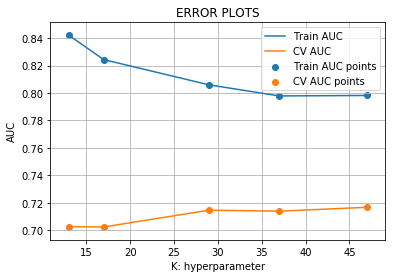

In [40]:
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score

train_auc = []
cv_auc = []
K = [13, 17, 29, 37, 47] #Choosing only odd numbers as even 'K' will lead to complications.
for i in K:
    neigh = KNeighborsClassifier(n_neighbors=i, algorithm='brute')
    neigh.fit(X_train_essay_bow, y_train)

    y_train_pred = batch_predict(neigh, X_train_essay_bow)    
    y_cv_pred = batch_predict(neigh, X_cv_essay_bow)

    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs        
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

plt.plot(K, train_auc, label='Train AUC')
plt.plot(K, cv_auc, label='CV AUC')

plt.scatter(K, train_auc, label='Train AUC points')
plt.scatter(K, cv_auc, label='CV AUC points')

plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

AUC of Train Data: 0.798
AUC of Test Data: 0.709


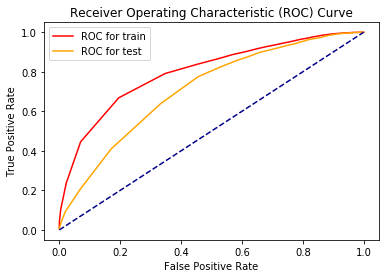

In [42]:
#Citation: plot roc auc curve
#url: https://stackabuse.com/understanding-roc-curves-with-python/
best_k = 47

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot

neigh = KNeighborsClassifier(n_neighbors=best_k, algorithm='brute')
neigh.fit(X_train_essay_bow, y_train)

def plot_roc_curve(test_fpr, test_tpr, train_fpr, train_tpr):  
    plt.plot(train_fpr, train_tpr, color='red', label='ROC for train')
    plt.plot(test_fpr, test_tpr, color='orange', label='ROC for test')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()
    
y_test_pred = neigh.predict_proba(X_test_essay_bow)  
y_test_pred = y_test_pred[:, 1]

y_train_pred = neigh.predict_proba(X_train_essay_bow)  
y_train_pred = y_train_pred[:, 1] 

auc_train = roc_auc_score(y_train, y_train_pred)  
print('AUC of Train Data: %.3f' % auc_train)  

auc_test = roc_auc_score(y_test, y_test_pred)  
print('AUC of Test Data: %.3f' % auc_test)  

train_fpr, train_tpr, train_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, test_thresholds = roc_curve(y_test, y_test_pred)  

plot_roc_curve(test_fpr, test_tpr, train_fpr, train_tpr)

In [46]:
# we are writing our own function for predict, with defined thresould
# we will pick a threshold that will give the least fpr
def predict(proba, threshould, fpr, tpr):
    
    t = threshould[np.argmax(tpr*(1-fpr))]
    
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    predictions = []
    for i in proba:
        if i>=t:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

Train confusion matrix
the maximum value of tpr*(1-fpr) 0.2494655451497283 for threshold 0.83


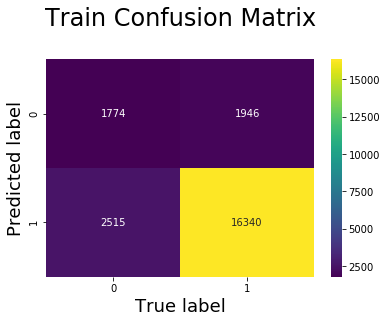

Test confusion matrix
the maximum value of tpr*(1-fpr) 0.2490285750404102 for threshold 0.851


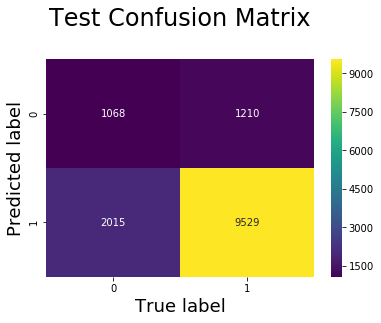

In [47]:
from sklearn.metrics import confusion_matrix

print("Train confusion matrix")
cm_train = confusion_matrix(y_train, predict(y_train_pred, train_thresholds, train_fpr, train_fpr))

class_names = ['negative','positive']
sns.heatmap(cm_train, annot=True, fmt='d',cmap='viridis')
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Train Confusion Matrix\n",size=24)
plt.show()

print("Test confusion matrix")
cm_test = confusion_matrix(y_test, predict(y_test_pred, test_thresholds, test_fpr, test_fpr))

class_names = ['negative','positive']
sns.heatmap(cm_test, annot=True, fmt='d',cmap='viridis')
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Test Confusion Matrix\n",size=24)
plt.show()

## Set 2: Review text, preprocessed one converted into vectors using (TFIDF)
<a id='set2'></a>

In [58]:
def batch_predict(clf, data):
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs

    y_data_pred = []
    tr_loop = data.shape[0] - data.shape[0]%1000
    # consider you X_tr shape is 49041, then your cr_loop will be 49041 - 49041%1000 = 49000
    # in this for loop we will iterate unti the last 1000 multiplier
    for i in range(0, tr_loop, 1000):
        y_data_pred.extend(clf.predict_proba(data[i:i+1000])[:,1])
    # we will be predicting for the last data points
    y_data_pred.extend(clf.predict_proba(data[tr_loop:])[:,1])
    
    return y_data_pred

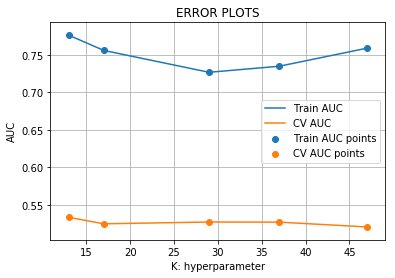

In [62]:
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score

train_auc = []
cv_auc = []
K = [13, 17, 29, 37, 47] #Choosing only odd numbers as even 'K' will lead to complications.
for i in K:
    neigh = KNeighborsClassifier(n_neighbors=i, algorithm='brute')
    neigh.fit(X_train_review_tfidf, y_train)

    y_train_pred = batch_predict(neigh, X_train_review_tfidf)    
    y_cv_pred = batch_predict(neigh, X_cv_review_tfidf)

    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs        
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

plt.plot(K, train_auc, label='Train AUC')
plt.plot(K, cv_auc, label='CV AUC')

plt.scatter(K, train_auc, label='Train AUC points')
plt.scatter(K, cv_auc, label='CV AUC points')

plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

AUC of Train Data: 0.776
AUC of Test Data: 0.530


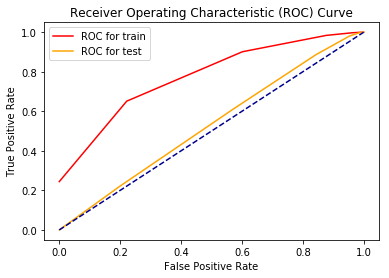

In [63]:
#Citation: plot roc auc curve
#url: https://stackabuse.com/understanding-roc-curves-with-python/
best_k = 13

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot

neigh = KNeighborsClassifier(n_neighbors=best_k, algorithm='brute')
neigh.fit(X_train_review_tfidf, y_train)

def plot_roc_curve(test_fpr, test_tpr, train_fpr, train_tpr):  
    plt.plot(train_fpr, train_tpr, color='red', label='ROC for train')
    plt.plot(test_fpr, test_tpr, color='orange', label='ROC for test')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()
    
y_test_pred = neigh.predict_proba(X_test_review_tfidf)  
y_test_pred = y_test_pred[:, 1]

y_train_pred = neigh.predict_proba(X_train_review_tfidf)  
y_train_pred = y_train_pred[:, 1] 

auc_train = roc_auc_score(y_train, y_train_pred)  
print('AUC of Train Data: %.3f' % auc_train)  

auc_test = roc_auc_score(y_test, y_test_pred)  
print('AUC of Test Data: %.3f' % auc_test)  

train_fpr, train_tpr, train_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, test_thresholds = roc_curve(y_test, y_test_pred)  

plot_roc_curve(test_fpr, test_tpr, train_fpr, train_tpr)

In [65]:
# we are writing our own function for predict, with defined thresould
# we will pick a threshold that will give the least fpr
def predict(proba, threshould, fpr, tpr):
    
    t = threshould[np.argmax(tpr*(1-fpr))]
    
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    predictions = []
    for i in proba:
        if i>=t:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

Train confusion matrix
the maximum value of tpr*(1-fpr) 0.2396748178980229 for threshold 0.846


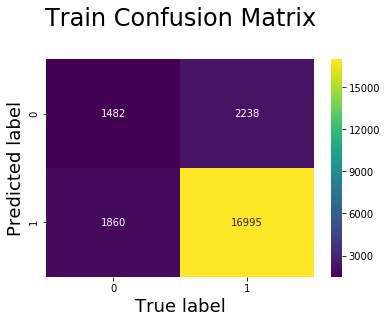

Test confusion matrix
the maximum value of tpr*(1-fpr) 0.24462565548541956 for threshold 0.923


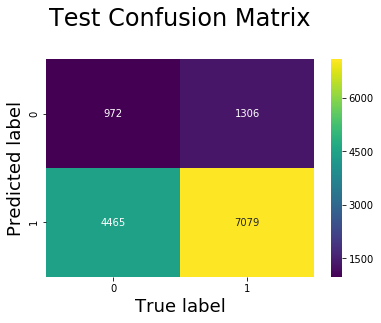

In [66]:
from sklearn.metrics import confusion_matrix

print("Train confusion matrix")
cm_train = confusion_matrix(y_train, predict(y_train_pred, train_thresholds, train_fpr, train_fpr))

class_names = ['negative','positive']
sns.heatmap(cm_train, annot=True, fmt='d',cmap='viridis')
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Train Confusion Matrix\n",size=24)
plt.show()

print("Test confusion matrix")
cm_test = confusion_matrix(y_test, predict(y_test_pred, test_thresholds, test_fpr, test_fpr))

class_names = ['negative','positive']
sns.heatmap(cm_test, annot=True, fmt='d',cmap='viridis')
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Test Confusion Matrix\n",size=24)
plt.show()

## Set 3: Review text, preprocessed one converted into vectors using (AVG W2V)
<a id='set3'></a>

In [31]:
def batch_predict(clf, data):
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs

    y_data_pred = []
    tr_loop = data.shape[0] - data.shape[0]%1000
    # consider you X_tr shape is 49041, then your cr_loop will be 49041 - 49041%1000 = 49000
    # in this for loop we will iterate unti the last 1000 multiplier
    for i in range(0, tr_loop, 1000):
        y_data_pred.extend(clf.predict_proba(data[i:i+1000])[:,1])
    # we will be predicting for the last data points
    y_data_pred.extend(clf.predict_proba(data[tr_loop:])[:,1])
    
    return y_data_pred

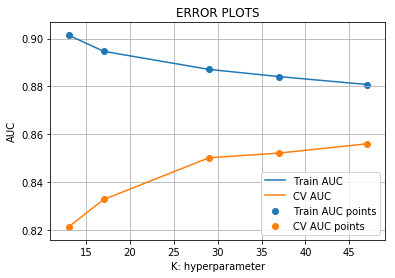

In [32]:
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score

train_auc = []
cv_auc = []
K = [13, 17, 29, 37, 47] #Choosing only odd numbers as even 'K' will lead to complications.
for i in K:
    neigh = KNeighborsClassifier(n_neighbors=i, algorithm='brute')
    neigh.fit(train_w2v_vectors_review, y_train)

    y_train_pred = batch_predict(neigh, train_w2v_vectors_review)    
    y_cv_pred = batch_predict(neigh, cv_w2v_vectors_reviews)

    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs        
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

plt.plot(K, train_auc, label='Train AUC')
plt.plot(K, cv_auc, label='CV AUC')

plt.scatter(K, train_auc, label='Train AUC points')
plt.scatter(K, cv_auc, label='CV AUC points')

plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

AUC of Train Data: 0.881
AUC of Test Data: 0.858


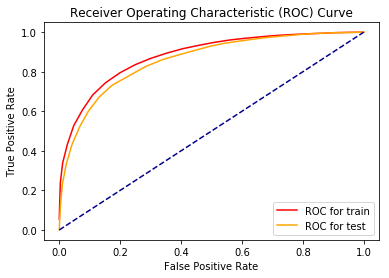

In [33]:
#Citation: plot roc auc curve
#url: https://stackabuse.com/understanding-roc-curves-with-python/
best_k = 47

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot

neigh = KNeighborsClassifier(n_neighbors=best_k, algorithm='brute')
neigh.fit(train_w2v_vectors_review, y_train)

def plot_roc_curve(test_fpr, test_tpr, train_fpr, train_tpr):  
    plt.plot(train_fpr, train_tpr, color='red', label='ROC for train')
    plt.plot(test_fpr, test_tpr, color='orange', label='ROC for test')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()
    
y_test_pred = neigh.predict_proba(test_w2v_vectors_reviews)  
y_test_pred = y_test_pred[:, 1]

y_train_pred = neigh.predict_proba(train_w2v_vectors_review)  
y_train_pred = y_train_pred[:, 1] 

auc_train = roc_auc_score(y_train, y_train_pred)  
print('AUC of Train Data: %.3f' % auc_train)  

auc_test = roc_auc_score(y_test, y_test_pred)  
print('AUC of Test Data: %.3f' % auc_test)  

train_fpr, train_tpr, train_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, test_thresholds = roc_curve(y_test, y_test_pred)  

plot_roc_curve(test_fpr, test_tpr, train_fpr, train_tpr)

In [34]:
# we are writing our own function for predict, with defined thresould
# we will pick a threshold that will give the least fpr
def predict(proba, threshould, fpr, tpr):
    
    t = threshould[np.argmax(tpr*(1-fpr))]
    
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    predictions = []
    for i in proba:
        if i>=t:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

Train confusion matrix
the maximum value of tpr*(1-fpr) 0.24991646433113654 for threshold 0.681


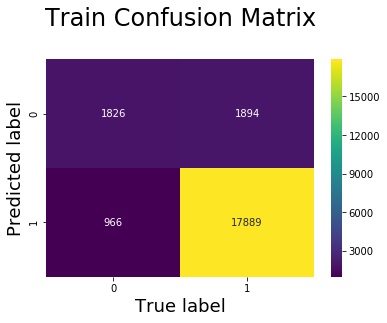

Test confusion matrix
the maximum value of tpr*(1-fpr) 0.24999518237968862 for threshold 0.702


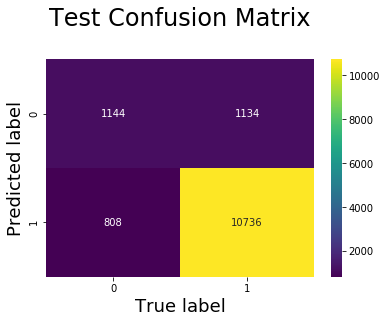

In [35]:
from sklearn.metrics import confusion_matrix

print("Train confusion matrix")
cm_train = confusion_matrix(y_train, predict(y_train_pred, train_thresholds, train_fpr, train_fpr))

class_names = ['negative','positive']
sns.heatmap(cm_train, annot=True, fmt='d',cmap='viridis')
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Train Confusion Matrix\n",size=24)
plt.show()

print("Test confusion matrix")
cm_test = confusion_matrix(y_test, predict(y_test_pred, test_thresholds, test_fpr, test_fpr))

class_names = ['negative','positive']
sns.heatmap(cm_test, annot=True, fmt='d',cmap='viridis')
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Test Confusion Matrix\n",size=24)
plt.show()

## Set 4: Review text, preprocessed one converted into vectors using (TFIDF W2V)
<a id='set4'></a>

In [30]:
def batch_predict(clf, data):
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs

    y_data_pred = []
    tr_loop = data.shape[0] - data.shape[0]%1000
    # consider you X_tr shape is 49041, then your cr_loop will be 49041 - 49041%1000 = 49000
    # in this for loop we will iterate unti the last 1000 multiplier
    for i in range(0, tr_loop, 1000):
        y_data_pred.extend(clf.predict_proba(data[i:i+1000])[:,1])
    # we will be predicting for the last data points
    y_data_pred.extend(clf.predict_proba(data[tr_loop:])[:,1])
    
    return y_data_pred

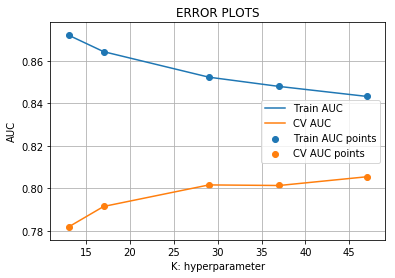

In [31]:
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score

train_auc = []
cv_auc = []
K = [13, 17, 29, 37, 47] #Choosing only odd numbers as even 'K' will lead to complications.
for i in K:
    neigh = KNeighborsClassifier(n_neighbors=i, algorithm='brute')
    neigh.fit(train_tfidf_w2v_reviews, y_train)

    y_train_pred = batch_predict(neigh, train_tfidf_w2v_reviews)    
    y_cv_pred = batch_predict(neigh, cv_tfidf_w2v_reviews)

    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs        
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

plt.plot(K, train_auc, label='Train AUC')
plt.plot(K, cv_auc, label='CV AUC')

plt.scatter(K, train_auc, label='Train AUC points')
plt.scatter(K, cv_auc, label='CV AUC points')

plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

AUC of Train Data: 0.843
AUC of Test Data: 0.809


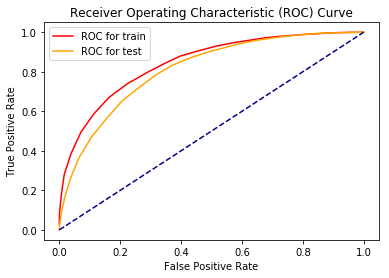

In [32]:
#Citation: plot roc auc curve
#url: https://stackabuse.com/understanding-roc-curves-with-python/
best_k = 47

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot

neigh = KNeighborsClassifier(n_neighbors=best_k, algorithm='brute')
neigh.fit(train_tfidf_w2v_reviews, y_train)

def plot_roc_curve(test_fpr, test_tpr, train_fpr, train_tpr):  
    plt.plot(train_fpr, train_tpr, color='red', label='ROC for train')
    plt.plot(test_fpr, test_tpr, color='orange', label='ROC for test')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()
    
y_test_pred = neigh.predict_proba(test_tfidf_w2v_reviews)  
y_test_pred = y_test_pred[:, 1]

y_train_pred = neigh.predict_proba(train_tfidf_w2v_reviews)  
y_train_pred = y_train_pred[:, 1] 

auc_train = roc_auc_score(y_train, y_train_pred)  
print('AUC of Train Data: %.3f' % auc_train)  

auc_test = roc_auc_score(y_test, y_test_pred)  
print('AUC of Test Data: %.3f' % auc_test)  

train_fpr, train_tpr, train_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, test_thresholds = roc_curve(y_test, y_test_pred)  

plot_roc_curve(test_fpr, test_tpr, train_fpr, train_tpr)

In [33]:
# we are writing our own function for predict, with defined thresould
# we will pick a threshold that will give the least fpr
def predict(proba, threshould, fpr, tpr):
    
    t = threshould[np.argmax(tpr*(1-fpr))]
    
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    predictions = []
    for i in proba:
        if i>=t:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

Train confusion matrix
the maximum value of tpr*(1-fpr) 0.24960428951323851 for threshold 0.723


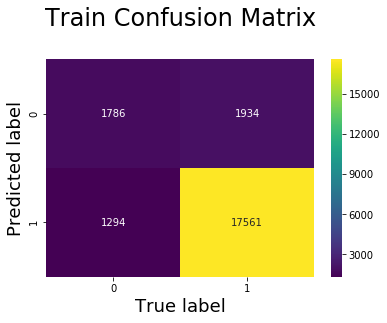

Test confusion matrix
the maximum value of tpr*(1-fpr) 0.24999922918075015 for threshold 0.745


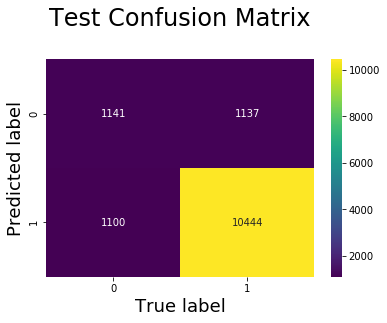

In [34]:
from sklearn.metrics import confusion_matrix

print("Train confusion matrix")
cm_train = confusion_matrix(y_train, predict(y_train_pred, train_thresholds, train_fpr, train_fpr))

class_names = ['negative','positive']
sns.heatmap(cm_train, annot=True, fmt='d',cmap='viridis')
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Train Confusion Matrix\n",size=24)
plt.show()

print("Test confusion matrix")
cm_test = confusion_matrix(y_test, predict(y_test_pred, test_thresholds, test_fpr, test_fpr))

class_names = ['negative','positive']
sns.heatmap(cm_test, annot=True, fmt='d',cmap='viridis')
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Test Confusion Matrix\n",size=24)
plt.show()

# 5. Applying k-NN (KD Tree)

<a id='knnkdtree'></a>

## SET 5: Review text, preprocessed one converted into vectors using (BOW) but with restriction on maximum features generated.

<a id='set5'></a>

In [28]:
def batch_predict(clf, data):
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs

    y_data_pred = []
    tr_loop = data.shape[0] - data.shape[0]%1000
    # consider you X_tr shape is 49041, then your cr_loop will be 49041 - 49041%1000 = 49000
    # in this for loop we will iterate unti the last 1000 multiplier
    for i in range(0, tr_loop, 1000):
        y_data_pred.extend(clf.predict_proba(data[i:i+1000])[:,1])
    # we will be predicting for the last data points
    y_data_pred.extend(clf.predict_proba(data[tr_loop:])[:,1])
    
    return y_data_pred

In [29]:
#sklearn implementation of kd-tree accepts only dense matrices, 
#Hence I converted the sparse matrices of CountVectorizer/TfidfVectorizer into dense matices. 
#You can convert sparse matrices to dense using .toarray() attribute.

X_train_review_bow = X_train_review_bow.toarray()
X_test_review_bow = X_test_review_bow.toarray()
X_cv_review_bow = X_cv_review_bow.toarray() 

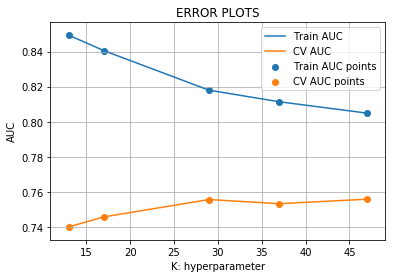

In [30]:
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score

train_auc = []
cv_auc = []
K = [13, 17, 29, 37, 47] #Choosing only odd numbers as even 'K' will lead to complications.

for i in K:
    neigh = KNeighborsClassifier(n_neighbors=i, algorithm='kd_tree')
    neigh.fit(X_train_review_bow, y_train)

    y_train_pred = batch_predict(neigh, X_train_review_bow)    
    y_cv_pred = batch_predict(neigh, X_cv_review_bow)

    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs        
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

plt.plot(K, train_auc, label='Train AUC')
plt.plot(K, cv_auc, label='CV AUC')

plt.scatter(K, train_auc, label='Train AUC points')
plt.scatter(K, cv_auc, label='CV AUC points')

plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

AUC of Train Data: 0.805
AUC of Test Data: 0.755


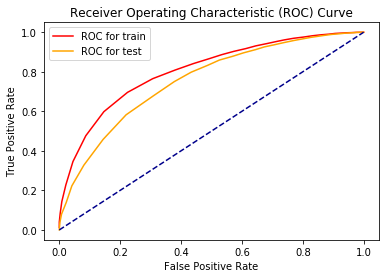

In [31]:
#Citation: plot roc auc curve
#url: https://stackabuse.com/understanding-roc-curves-with-python/
best_k = 47

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot

neigh = KNeighborsClassifier(n_neighbors=best_k, algorithm='kd_tree')
neigh.fit(X_train_review_bow, y_train)

def plot_roc_curve(test_fpr, test_tpr, train_fpr, train_tpr):  
    plt.plot(train_fpr, train_tpr, color='red', label='ROC for train')
    plt.plot(test_fpr, test_tpr, color='orange', label='ROC for test')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()
    
y_test_pred = neigh.predict_proba(X_test_review_bow)  
y_test_pred = y_test_pred[:, 1]

y_train_pred = neigh.predict_proba(X_train_review_bow)  
y_train_pred = y_train_pred[:, 1] 

auc_train = roc_auc_score(y_train, y_train_pred)  
print('AUC of Train Data: %.3f' % auc_train)  

auc_test = roc_auc_score(y_test, y_test_pred)  
print('AUC of Test Data: %.3f' % auc_test)  

train_fpr, train_tpr, train_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, test_thresholds = roc_curve(y_test, y_test_pred)  

plot_roc_curve(test_fpr, test_tpr, train_fpr, train_tpr)

In [32]:
# we are writing our own function for predict, with defined thresould
# we will pick a threshold that will give the least fpr
def predict(proba, threshould, fpr, tpr):
    
    t = threshould[np.argmax(tpr*(1-fpr))]
    
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    predictions = []
    for i in proba:
        if i>=t:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

Train confusion matrix
the maximum value of tpr*(1-fpr) 0.24994732049947974 for threshold 0.745


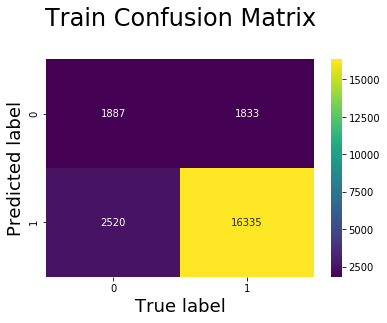

Test confusion matrix
the maximum value of tpr*(1-fpr) 0.24984891942703463 for threshold 0.766


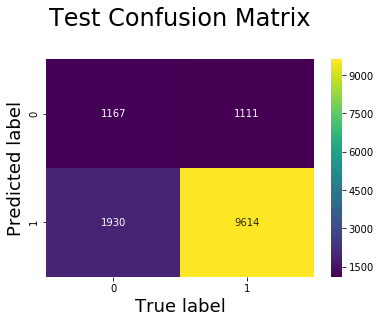

In [33]:
from sklearn.metrics import confusion_matrix

print("Train confusion matrix")
cm_train = confusion_matrix(y_train, predict(y_train_pred, train_thresholds, train_fpr, train_fpr))

class_names = ['negative','positive']
sns.heatmap(cm_train, annot=True, fmt='d',cmap='viridis')
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Train Confusion Matrix\n",size=24)
plt.show()

print("Test confusion matrix")
cm_test = confusion_matrix(y_test, predict(y_test_pred, test_thresholds, test_fpr, test_fpr))

class_names = ['negative','positive']
sns.heatmap(cm_test, annot=True, fmt='d',cmap='viridis')
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Test Confusion Matrix\n",size=24)
plt.show()

## SET 6: Review text, preprocessed one converted into vectors using (TFIDF) but with restriction on maximum features generated.

<a id='set6'></a>

In [28]:
def batch_predict(clf, data):
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs

    y_data_pred = []
    tr_loop = data.shape[0] - data.shape[0]%1000
    # consider you X_tr shape is 49041, then your cr_loop will be 49041 - 49041%1000 = 49000
    # in this for loop we will iterate unti the last 1000 multiplier
    for i in range(0, tr_loop, 1000):
        y_data_pred.extend(clf.predict_proba(data[i:i+1000])[:,1])
    # we will be predicting for the last data points
    y_data_pred.extend(clf.predict_proba(data[tr_loop:])[:,1])
    
    return y_data_pred

In [29]:
#Converting to dense matrices
X_train_review_tfidf = X_train_review_tfidf.toarray()
X_cv_review_tfidf = X_cv_review_tfidf.toarray()
X_test_review_tfidf = X_test_review_tfidf.toarray()

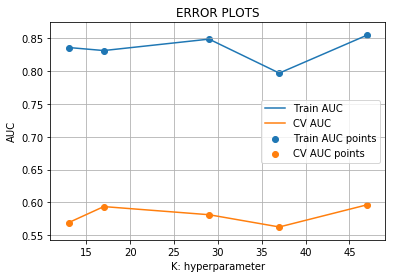

In [31]:
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score

train_auc = []
cv_auc = []
K = [13, 17, 29, 37, 47] #Choosing only odd numbers as even 'K' will lead to complications.

for i in K:
    neigh = KNeighborsClassifier(n_neighbors=i, algorithm='kd_tree')
    neigh.fit(X_train_review_tfidf, y_train)

    y_train_pred = batch_predict(neigh, X_train_review_tfidf)    
    y_cv_pred = batch_predict(neigh, X_cv_review_tfidf)

    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs        
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

plt.plot(K, train_auc, label='Train AUC')
plt.plot(K, cv_auc, label='CV AUC')

plt.scatter(K, train_auc, label='Train AUC points')
plt.scatter(K, cv_auc, label='CV AUC points')

plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

AUC of Train Data: 0.855
AUC of Test Data: 0.591


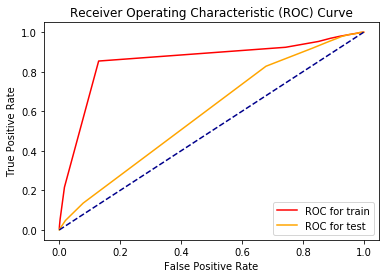

In [32]:
#Citation: plot roc auc curve
#url: https://stackabuse.com/understanding-roc-curves-with-python/
best_k = 47

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot

neigh = KNeighborsClassifier(n_neighbors=best_k, algorithm='kd_tree')
neigh.fit(X_train_review_tfidf, y_train)

def plot_roc_curve(test_fpr, test_tpr, train_fpr, train_tpr):  
    plt.plot(train_fpr, train_tpr, color='red', label='ROC for train')
    plt.plot(test_fpr, test_tpr, color='orange', label='ROC for test')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()
    
y_test_pred = neigh.predict_proba(X_test_review_tfidf)  
y_test_pred = y_test_pred[:, 1]

y_train_pred = neigh.predict_proba(X_train_review_tfidf)  
y_train_pred = y_train_pred[:, 1] 

auc_train = roc_auc_score(y_train, y_train_pred)  
print('AUC of Train Data: %.3f' % auc_train)  

auc_test = roc_auc_score(y_test, y_test_pred)  
print('AUC of Test Data: %.3f' % auc_test)  

train_fpr, train_tpr, train_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, test_thresholds = roc_curve(y_test, y_test_pred)  

plot_roc_curve(test_fpr, test_tpr, train_fpr, train_tpr)

In [33]:
# we are writing our own function for predict, with defined thresould
# we will pick a threshold that will give the least fpr
def predict(proba, threshould, fpr, tpr):
    
    t = threshould[np.argmax(tpr*(1-fpr))]
    
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    predictions = []
    for i in proba:
        if i>=t:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

Train confusion matrix
the maximum value of tpr*(1-fpr) 0.19068418314255983 for threshold 0.894


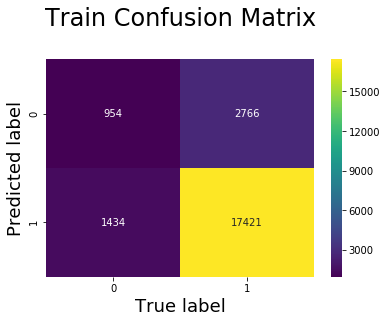

Test confusion matrix
the maximum value of tpr*(1-fpr) 0.217921586099354 for threshold 0.915


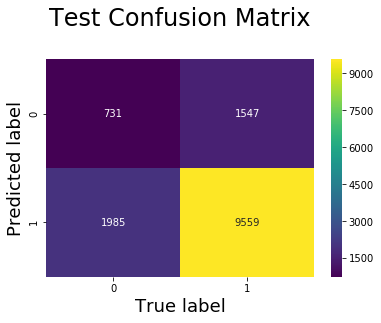

In [34]:
from sklearn.metrics import confusion_matrix

print("Train confusion matrix")
cm_train = confusion_matrix(y_train, predict(y_train_pred, train_thresholds, train_fpr, train_fpr))

class_names = ['negative','positive']
sns.heatmap(cm_train, annot=True, fmt='d',cmap='viridis')
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Train Confusion Matrix\n",size=24)
plt.show()

print("Test confusion matrix")
cm_test = confusion_matrix(y_test, predict(y_test_pred, test_thresholds, test_fpr, test_fpr))

class_names = ['negative','positive']
sns.heatmap(cm_test, annot=True, fmt='d',cmap='viridis')
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Test Confusion Matrix\n",size=24)
plt.show()

## SET 7: Review text, preprocessed one converted into vectors using (AVG W2V) but with restriction on maximum features generated.

<a id='set7'></a>

In [30]:
def batch_predict(clf, data):
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs

    y_data_pred = []
    tr_loop = data.shape[0] - data.shape[0]%1000
    # consider you X_tr shape is 49041, then your cr_loop will be 49041 - 49041%1000 = 49000
    # in this for loop we will iterate unti the last 1000 multiplier
    for i in range(0, tr_loop, 1000):
        y_data_pred.extend(clf.predict_proba(data[i:i+1000])[:,1])
    # we will be predicting for the last data points
    y_data_pred.extend(clf.predict_proba(data[tr_loop:])[:,1])
    
    return y_data_pred

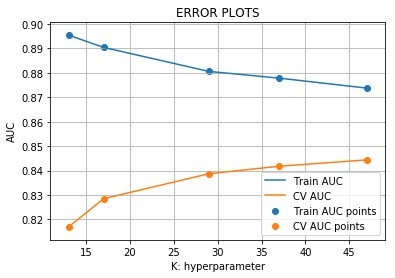

In [31]:
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score

train_auc = []
cv_auc = []
K = [13, 17, 29, 37, 47] #Choosing only odd numbers as even 'K' will lead to complications.
for i in K:
    neigh = KNeighborsClassifier(n_neighbors=i, algorithm='kd_tree')
    neigh.fit(train_w2v_vectors_review, y_train)

    y_train_pred = batch_predict(neigh, train_w2v_vectors_review)    
    y_cv_pred = batch_predict(neigh, cv_w2v_vectors_reviews)

    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs        
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

plt.plot(K, train_auc, label='Train AUC')
plt.plot(K, cv_auc, label='CV AUC')

plt.scatter(K, train_auc, label='Train AUC points')
plt.scatter(K, cv_auc, label='CV AUC points')

plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

AUC of Train Data: 0.874
AUC of Test Data: 0.846


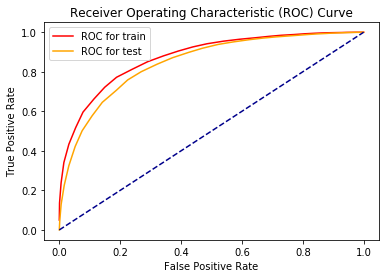

In [32]:
#Citation: plot roc auc curve
#url: https://stackabuse.com/understanding-roc-curves-with-python/
best_k = 47

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot

neigh = KNeighborsClassifier(n_neighbors=best_k, algorithm='kd_tree')
neigh.fit(train_w2v_vectors_review, y_train)

def plot_roc_curve(test_fpr, test_tpr, train_fpr, train_tpr):  
    plt.plot(train_fpr, train_tpr, color='red', label='ROC for train')
    plt.plot(test_fpr, test_tpr, color='orange', label='ROC for test')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()
    
y_test_pred = neigh.predict_proba(test_w2v_vectors_reviews)  
y_test_pred = y_test_pred[:, 1]

y_train_pred = neigh.predict_proba(train_w2v_vectors_review)  
y_train_pred = y_train_pred[:, 1] 

auc_train = roc_auc_score(y_train, y_train_pred)  
print('AUC of Train Data: %.3f' % auc_train)  

auc_test = roc_auc_score(y_test, y_test_pred)  
print('AUC of Test Data: %.3f' % auc_test)  

train_fpr, train_tpr, train_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, test_thresholds = roc_curve(y_test, y_test_pred)  

plot_roc_curve(test_fpr, test_tpr, train_fpr, train_tpr)

In [33]:
# we are writing our own function for predict, with defined thresould
# we will pick a threshold that will give the least fpr
def predict(proba, threshould, fpr, tpr):
    
    t = threshould[np.argmax(tpr*(1-fpr))]
    
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    predictions = []
    for i in proba:
        if i>=t:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

Train confusion matrix
the maximum value of tpr*(1-fpr) 0.24978140536478205 for threshold 0.681


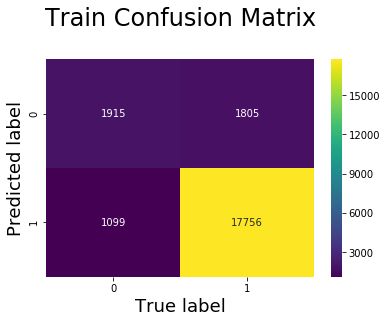

Test confusion matrix
the maximum value of tpr*(1-fpr) 0.24953731574529356 for threshold 0.681


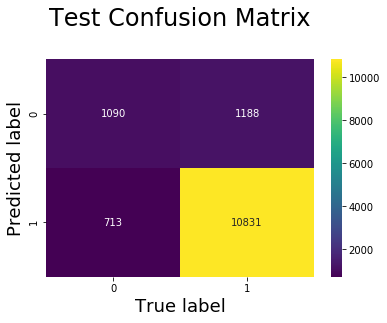

In [34]:
from sklearn.metrics import confusion_matrix

print("Train confusion matrix")
cm_train = confusion_matrix(y_train, predict(y_train_pred, train_thresholds, train_fpr, train_fpr))

class_names = ['negative','positive']
sns.heatmap(cm_train, annot=True, fmt='d',cmap='viridis')
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Train Confusion Matrix\n",size=24)
plt.show()

print("Test confusion matrix")
cm_test = confusion_matrix(y_test, predict(y_test_pred, test_thresholds, test_fpr, test_fpr))

class_names = ['negative','positive']
sns.heatmap(cm_test, annot=True, fmt='d',cmap='viridis')
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Test Confusion Matrix\n",size=24)
plt.show()

## SET 8: Review text, preprocessed one converted into vectors using (TFIDF AVG W2V) but with restriction on maximum features generated.

<a id='set8'></a>

In [29]:
def batch_predict(clf, data):
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs

    y_data_pred = []
    tr_loop = data.shape[0] - data.shape[0]%1000
    # consider you X_tr shape is 49041, then your cr_loop will be 49041 - 49041%1000 = 49000
    # in this for loop we will iterate unti the last 1000 multiplier
    for i in range(0, tr_loop, 1000):
        y_data_pred.extend(clf.predict_proba(data[i:i+1000])[:,1])
    # we will be predicting for the last data points
    y_data_pred.extend(clf.predict_proba(data[tr_loop:])[:,1])
    
    return y_data_pred

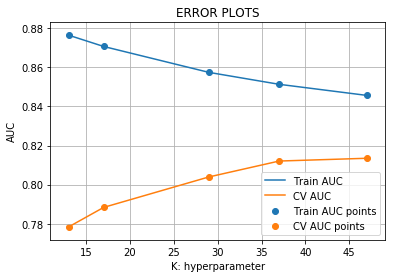

In [31]:
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score

train_auc = []
cv_auc = []
K = [13, 17, 29, 37, 47] #Choosing only odd numbers as even 'K' will lead to complications.
for i in K:
    neigh = KNeighborsClassifier(n_neighbors=i, algorithm='kd_tree')
    neigh.fit(train_tfidf_w2v_reviews, y_train)

    y_train_pred = batch_predict(neigh, train_tfidf_w2v_reviews)    
    y_cv_pred = batch_predict(neigh, cv_tfidf_w2v_reviews)

    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs        
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

plt.plot(K, train_auc, label='Train AUC')
plt.plot(K, cv_auc, label='CV AUC')

plt.scatter(K, train_auc, label='Train AUC points')
plt.scatter(K, cv_auc, label='CV AUC points')

plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

AUC of Train Data: 0.846
AUC of Test Data: 0.800


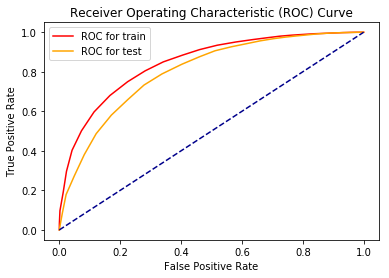

In [32]:
#Citation: plot roc auc curve
#url: https://stackabuse.com/understanding-roc-curves-with-python/
best_k = 47

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot

neigh = KNeighborsClassifier(n_neighbors=best_k, algorithm='kd_tree')
neigh.fit(train_tfidf_w2v_reviews, y_train)

def plot_roc_curve(test_fpr, test_tpr, train_fpr, train_tpr):  
    plt.plot(train_fpr, train_tpr, color='red', label='ROC for train')
    plt.plot(test_fpr, test_tpr, color='orange', label='ROC for test')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()
    
y_test_pred = neigh.predict_proba(test_tfidf_w2v_reviews)  
y_test_pred = y_test_pred[:, 1]

y_train_pred = neigh.predict_proba(train_tfidf_w2v_reviews)  
y_train_pred = y_train_pred[:, 1] 

auc_train = roc_auc_score(y_train, y_train_pred)  
print('AUC of Train Data: %.3f' % auc_train)  

auc_test = roc_auc_score(y_test, y_test_pred)  
print('AUC of Test Data: %.3f' % auc_test)  

train_fpr, train_tpr, train_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, test_thresholds = roc_curve(y_test, y_test_pred)  

plot_roc_curve(test_fpr, test_tpr, train_fpr, train_tpr)

In [33]:
# we are writing our own function for predict, with defined thresould
# we will pick a threshold that will give the least fpr
def predict(proba, threshould, fpr, tpr):
    
    t = threshould[np.argmax(tpr*(1-fpr))]
    
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    predictions = []
    for i in proba:
        if i>=t:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

Train confusion matrix
the maximum value of tpr*(1-fpr) 0.2496357237830963 for threshold 0.723


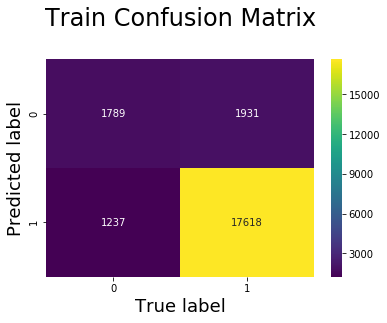

Test confusion matrix
the maximum value of tpr*(1-fpr) 0.2498595181917197 for threshold 0.745


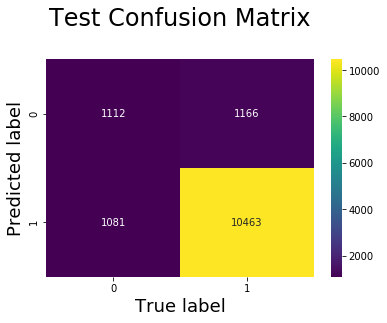

In [34]:
from sklearn.metrics import confusion_matrix

print("Train confusion matrix")
cm_train = confusion_matrix(y_train, predict(y_train_pred, train_thresholds, train_fpr, train_fpr))

class_names = ['negative','positive']
sns.heatmap(cm_train, annot=True, fmt='d',cmap='viridis')
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Train Confusion Matrix\n",size=24)
plt.show()

print("Test confusion matrix")
cm_test = confusion_matrix(y_test, predict(y_test_pred, test_thresholds, test_fpr, test_fpr))

class_names = ['negative','positive']
sns.heatmap(cm_test, annot=True, fmt='d',cmap='viridis')
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Test Confusion Matrix\n",size=24)
plt.show()

# 6. Conclusion
<a id='conc'> </a>

In [36]:
from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = ["Set", "Vectorizer", "Model", "Best Hyper-parameter (K)", "AUC of Test Data"]

x.add_row(["Set 1", "Bag Of Words", "Brute", 47, 0.709])
x.add_row(["Set 2", "TF-IDF", "Brute", 13, 0.530])
x.add_row(["Set 3", "AVG W2V", "Brute", 47, 0.858])
x.add_row(["Set 4", "TF-IDF AVG W2V", "Brute", 47, 0.809])
x.add_row(["Set 5", "Bag of Words", "KD Tree", 47, 0.755])
x.add_row(["Set 6", "TFIDF", "KD Tree", 47, 0.591])
x.add_row(["Set 7", "AVG W2V", "KD Tree", 47, 0.846])
x.add_row(["Set 8", "TFIDF AVG W2V", "KD Tree", 47, 0.800])

print(x)

+-------+----------------+---------+--------------------------+------------------+
|  Set  |   Vectorizer   |  Model  | Best Hyper-parameter (K) | AUC of Test Data |
+-------+----------------+---------+--------------------------+------------------+
| Set 1 |  Bag Of Words  |  Brute  |            47            |      0.709       |
| Set 2 |     TF-IDF     |  Brute  |            13            |       0.53       |
| Set 3 |    AVG W2V     |  Brute  |            47            |      0.858       |
| Set 4 | TF-IDF AVG W2V |  Brute  |            47            |      0.809       |
| Set 5 |  Bag of Words  | KD Tree |            47            |      0.755       |
| Set 6 |     TFIDF      | KD Tree |            47            |      0.591       |
| Set 7 |    AVG W2V     | KD Tree |            47            |      0.846       |
| Set 8 | TFIDF AVG W2V  | KD Tree |            47            |       0.8        |
+-------+----------------+---------+--------------------------+------------------+
